In [1]:

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
import matplotlib.pyplot as plt  # pylint: disable=unused-import
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# pretty progress bar
from tqdm.auto import tqdm  # pylint: disable=unused-import
# augmentation imports
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import MultiStepLR


from collections import defaultdict, deque

import cv2
import collections
import os
import numpy as np

import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
import torchvision
import random
from torch.utils.data import DataLoader, Dataset, sampler
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,VerticalFlip,Cutout,SmallestMaxSize,
                            ToGray, ShiftScaleRotate, Blur,Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import copy
from torch.autograd import Variable
import torchvision.transforms.functional as TF
import random

In [2]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.eps = eps=1e-5
    
        # define the forward pass
    def forward(self, preds, targets):  # pylint: disable=unused-argument
        """
            Compute Soft-Dice Loss.

            Arguments:
                preds (torch.FloatTensor):
                    tensor of predicted labels. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor):
                    tensor of ground-truth labels. The shape of the tensor is (B, 1, H, W).
            Returns:
                mean_loss (float32): mean loss by class  value.
        """
        loss = 0
        #loss = Variable(loss)
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection
            intersection = (pred * target).sum()
            
            union = (pred + target).sum()

            # compute dice coefficient
            dice = (2 * intersection + self.eps) / (union + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            #loss = loss - dice.log()

            # get mean loss by class value
            loss = 1- (dice / self.num_classes)

        return loss

# create SoftDiceLoss class inherited from nn.Module
class SoftDiceLoss(nn.Module):
    """
        Implementation of the Soft-Dice Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes=12, eps=1e-5):
        super().__init__()
        # init class fields
        self.num_classes = num_classes
        self.eps = eps

    # define the forward pass
    def forward(self, preds, targets):  # pylint: disable=unused-argument
        """
            Compute Soft-Dice Loss.

            Arguments:
                preds (torch.FloatTensor):
                    tensor of predicted labels. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor):
                    tensor of ground-truth labels. The shape of the tensor is (B, 1, H, W).
            Returns:
                mean_loss (float32): mean loss by class  value.
        """
        loss = 0
        #loss = Variable(loss)
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection
            intersection = (pred * target).sum()

            # compute dice coefficient
            dice = (2 * intersection + self.eps) / (pred.sum() + target.sum() + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - dice.log()

            # get mean loss by class value
            loss = loss / self.num_classes

        return loss

In [3]:
def train_model(model, optimizer, dataloaders, device, scheduler, num_epochs=25, print_freq=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e15

    loss_func = DiceLoss() #nn.BCEWithLogitsLoss() 

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        loss_history = {'train': [], 'val': []}
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            inner_tq = tqdm(dataloaders[phase], total=len(dataloaders[phase]), leave=False)
            for images,msks in inner_tq :
                #imgs = Variable(images).cuda()
                #msks = Variable(msks).cuda()
                imgs = images.to(device)
                msks = msks.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    loss = loss_func(outputs['out'][:,:, :, :].uniform_().softmax(dim=1), msks)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            if phase == 'train':
                scheduler.step()

            epoch_loss = np.float(loss.data)
            if (epoch + 1) % print_freq == 0:
                print('Epoch: [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, epoch_loss))
                loss_history[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best loss Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_history

In [4]:
def init_semantic_segmentation_dataset(data_path,mode):
    """ Prepare Semantic Segmentation dataset

    Arguments:
        data_path (string): path to dataset.
        imgs_folder (string): path to images (related of the data_path).
        masks_folder (string): path to masks (related of the data_path).

    Initialise dataset as a list of pairs {"image": <path_to_image>, "mask": <path_to_mask>}.
    """
    if mode == "train":
        imgs_folder =str("train" )
        masks_folder=str("trainannot")
        names = os.listdir(os.path.join(data_path, imgs_folder))
        dataset = []
        for name in names:
            name_wth_ext = name.rsplit(".",1)[0] + '.png'
            dataset.append({
                "image": os.path.join(data_path, imgs_folder, name),
                "mask": os.path.join(data_path, masks_folder, name_wth_ext)
            })
    elif mode == "val":
        imgs_folder =str("val" )
        masks_folder=str("valannot")
        names = os.listdir(os.path.join(data_path, imgs_folder))
        dataset = []
        for name in names:
            name_wth_ext = name.rsplit(".",1)[0] + '.png'
            dataset.append({
                "image": os.path.join(data_path, imgs_folder, name),
                "mask": os.path.join(data_path, masks_folder, name_wth_ext)
            })
    else:
        imgs_folder=str("test")
        names = os.listdir(os.path.join(data_path, imgs_folder))
        dataset = []
        for name in names:
            dataset.append({
                "image": os.path.join(data_path, imgs_folder, name),
            })

    return dataset

In [5]:
# dataset class implementation
class ImageData(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
    def __init__(
        self,
        data_path,
        mode,
        num_classes,
    ):

        self.num_classes = num_classes
        self.transforms_general = transforms.Compose([transforms.Resize((300,300)),
                                  transforms.ColorJitter(hue=.05, saturation=.05),
                                ])
        self.transforms_img =  transforms.Compose([ transforms.ToTensor(),
                                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                  ])                                
        # check wether dataset loading parameters exist
        # get the map of image-mask pairs
        
        self.mode = mode
        self.dataset = init_semantic_segmentation_dataset(data_path,self.mode)
        


    # get dataset's length
    def __len__(self):
        return len(self.dataset)
    
    def transform_rotate(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(300, 300))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(300, 300))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        #image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)
        return image, mask

        # get item by index
    def __getitem__(self, idx):
            if self.mode == "train":
                img = Image.open(self.dataset[idx]["image"])#[..., ::-1]
                mask = Image.open(self.dataset[idx]["mask"])
                img = self.transforms_general(img)
                mask = self.transforms_general(mask)
                img,mask = self.transform_rotate(img,mask)
                img = self.transforms_img(img)
                return img, np.asarray(mask)
            elif self.mode == "val":
                img = Image.open(self.dataset[idx]["image"])#[..., ::-1]
                mask = Image.open(self.dataset[idx]["mask"])
                img = self.transforms_general(img)
                mask = self.transforms_general(mask)
                img,mask = self.transform_rotate(img,mask)
                img = self.transforms_img(img)
                return img, np.asarray(mask)
            else:
                img = Image.open(self.dataset[idx]["image"])
                img = self.transforms_img(img)
                return img

In [6]:
train_data = ImageData(data_path="./data",mode="train",num_classes=12)
val_data = ImageData(data_path="./data",mode="val",num_classes=12)

In [7]:
img1,msk1 = train_data.__getitem__(100)
img2,msk2 = train_data.__getitem__(200)
img3,msk3 = train_data.__getitem__(500)
img4,msk4 = val_data.__getitem__(100)

<IPython.core.display.Javascript object>


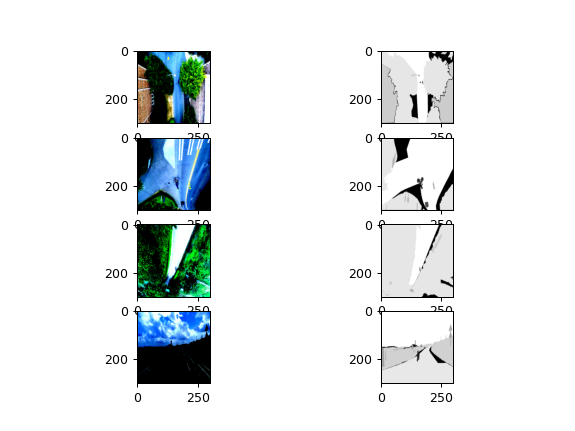

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [8]:
plt.figure()
plt.subplot(4,2,1)
plt.imshow(np.transpose(img1,(1,2,0)))
plt.subplot(4,2,3)
plt.imshow(np.transpose(img2,(1,2,0)))
plt.subplot(4,2,5)
plt.imshow(np.transpose(img3,(1,2,0)))
plt.subplot(4,2,7)
plt.imshow(np.transpose(img4,(1,2,0)))


plt.subplot(4,2,2)
plt.imshow(np.reshape(msk1,(300,300)),cmap='gray')
plt.subplot(4,2,4)
plt.imshow(np.reshape(msk2,(300,300)),cmap='gray')
plt.subplot(4,2,6)
plt.imshow(np.reshape(msk3,(300,300)),cmap='gray')
plt.subplot(4,2,8)
plt.imshow(np.reshape(msk4,(300,300)),cmap='gray')


plt.show()

In [9]:
num_classes=12
model_ft = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model_ft.classifier = DeepLabHead(2048, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
data_loader_train = torch.utils.data.DataLoader(
    train_data, batch_size=4, shuffle=True, num_workers=4,drop_last=True
)
data_loader_val = torch.utils.data.DataLoader(
    val_data, batch_size=4, shuffle=True, num_workers=4,drop_last=True
)

dataloaders = {'train': data_loader_train, 'val': data_loader_val}


In [11]:
# construct an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

In [12]:
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch)
    lr_scheduler.step()

In [13]:
total_epoch = 10
model_ft, lossDictSpan = train_model(model_ft, optimizer, dataloaders, device, lr_scheduler, total_epoch)


Epoch 0/9
----------


/media/hdd/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: [1/10], Loss: 0.9919


Epoch: [1/10], Loss: 1.0000
Epoch 1/9
----------


Epoch: [2/10], Loss: 1.0000


Epoch: [2/10], Loss: 1.0000
Epoch 2/9
----------


Epoch: [3/10], Loss: 1.0000


Epoch: [3/10], Loss: 1.0000
Epoch 3/9
----------


Epoch: [4/10], Loss: 0.9927


Epoch: [4/10], Loss: 0.9926
Epoch 4/9
----------


Epoch: [5/10], Loss: 0.9925


Epoch: [5/10], Loss: 1.0000
Epoch 5/9
----------


Epoch: [6/10], Loss: 1.0000


Epoch: [6/10], Loss: 1.0000
Epoch 6/9
----------


Epoch: [7/10], Loss: 0.9928


Epoch: [7/10], Loss: 1.0000
Epoch 7/9
----------


Epoch: [8/10], Loss: 1.0000


Epoch: [8/10], Loss: 0.9982
Epoch 8/9
----------


Epoch: [9/10], Loss: 1.0000


Epoch: [9/10], Loss: 1.0000
Epoch 9/9
----------


Epoch: [10/10], Loss: 1.0000


Epoch: [10/10], Loss: 0.9973
Training complete in 531m 19s
Best loss Acc: 0.992589


In [14]:
torch.save(model_ft.state_dict(), 'deeplabv3Resnet101_5EPH_TF_night.pth')
torch.cuda.empty_cache()

In [15]:
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.to(torch.device('cuda'))
model_ft.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [16]:
#model_ft.load_state_dict(torch.load("./deeplabv3Resnet101_5EPH_TF.pth"))


In [17]:
test_data = ImageData(data_path="data",mode="test",num_classes=12)

In [18]:
data_loader_test = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=True, num_workers=4,drop_last=True
)

In [19]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


In [20]:
def mask2rle(img,fname):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''   
    for j in range(12):        
        pixel= img.T.flatten()
        runs = np.where(pixel == j)[0]
        fn = str ('\n'+fname + "_"+ str(j))
        f.write(fn + ',')
        if len(runs) != 0:
            cons = consecutive(runs)
            for i in range(len(cons[:])):
                index = cons[i][0] 
                count = len(cons[i])
                f.write(str(index))
                f.write(' ')
                f.write(str(count))
                f.write(' ')
            continue
    return

In [21]:
model_ft.to('cuda')
f= open("./sub_13_night.csv","a+",encoding = "UTF-8")
f.write("ImageID" + ',' "EncodedPixels") 

for i in range(len(data_loader_test.dataset)):
    #input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    input_im = data_loader_test.dataset[i]
    #input_image=np.reshape(input_im,(3,720,1280))
    input_fname = data_loader_test.dataset.dataset[i]['image']
    input_image = input_im.unsqueeze(0)
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_image = input_image.to('cuda')

    with torch.no_grad():
        output = model_ft(input_image)['out'][0]
    output_predictions = output.argmax(0)
    head, tail = os.path.split(input_fname)
    fn=tail.split('.jpg')
    mask2rle(output_predictions.cpu().detach().numpy(),fn[0])
    
f.close()

In [39]:
#input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
input_im = data_loader_test.dataset[j]
#input_image=np.reshape(input_im,(3,720,1280))
input_fname = data_loader_test.dataset.dataset[200]['image']
input_image = input_im.unsqueeze(0)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_image = input_image.to('cuda')

with torch.no_grad():
    output = model_ft(input_image)['out'][0]
output_predictions = output.argmax(0)

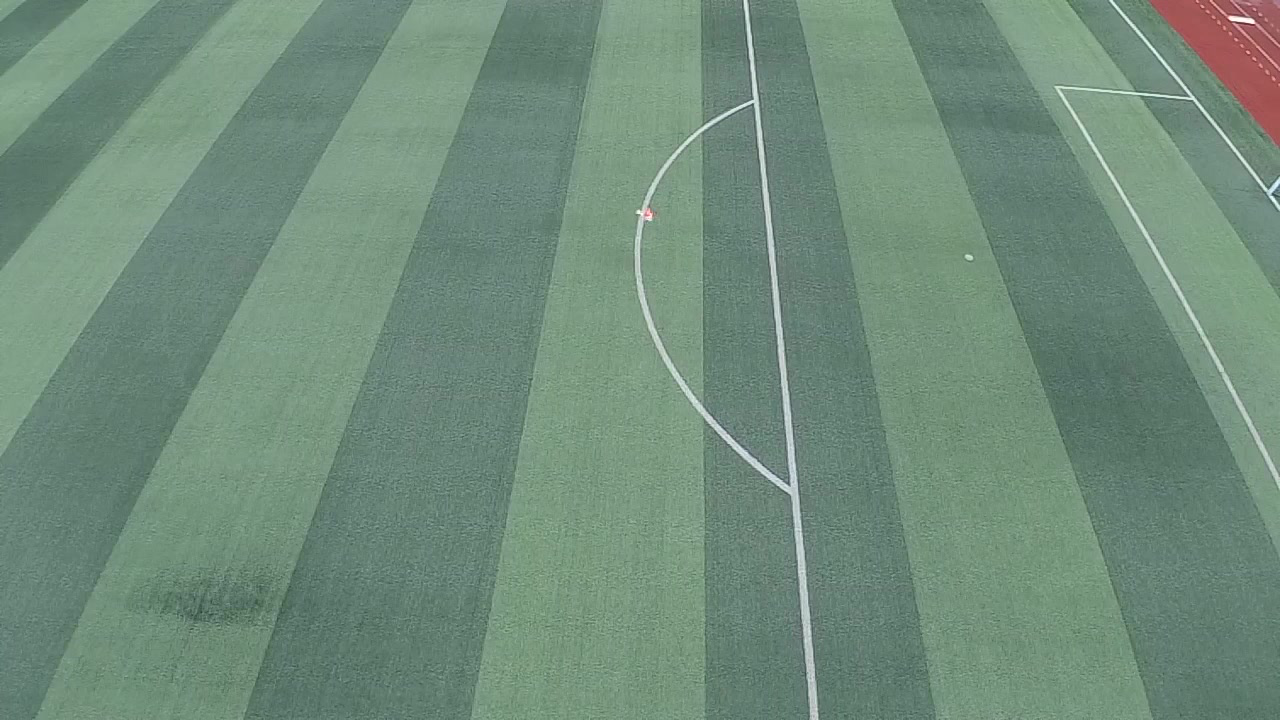

In [40]:
input_img=Image.open(input_fname)
input_img

In [36]:
output_predictions

tensor([[0, 0, 0,  ..., 8, 8, 8],
        [0, 0, 0,  ..., 8, 8, 8],
        [0, 0, 0,  ..., 8, 8, 8],
        ...,
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5]], device='cuda:0')

<IPython.core.display.Javascript object>


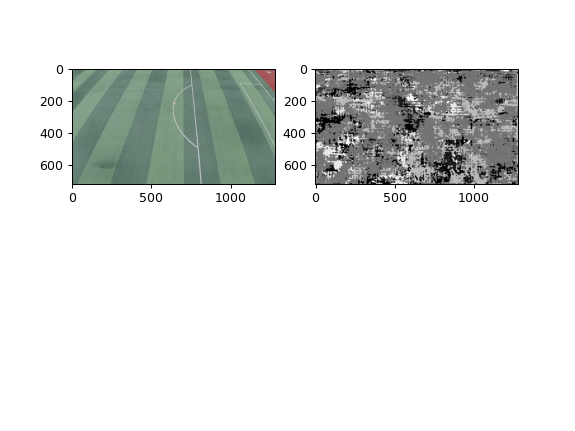

In [35]:

plt.figure()
plt.subplot(2,2,1)
plt.imshow(input_img)

plt.subplot(2,2,2)
plt.imshow(np.asarray(output_predictions.cpu()),cmap='gray')


plt.show()